# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [61]:
# Change here using YOUR first and last names
fn1 = "enrique"
ln1 = "gomez"
fn2 = "thihaiyen"
ln2 = "vu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_gomez_enrique_and_vu_thihaiyen.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [0]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [0]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None or new_grad is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


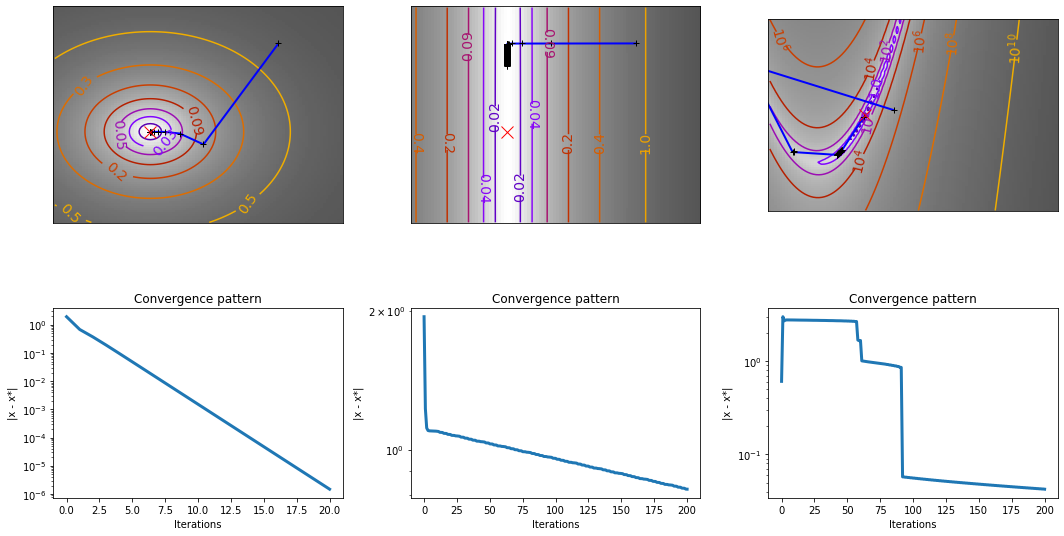

In [104]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [0]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.1
    c2 = 0.9
    max_iter = 100
    lambda_threshold = 0.1 # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO H = ..
        H = np.linalg.inv(f_hessian(x) + lambda_threshold * np.eye(len(x)))
        d = - H @ grad_x
                
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None or new_grad is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        d = - H @ grad_x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


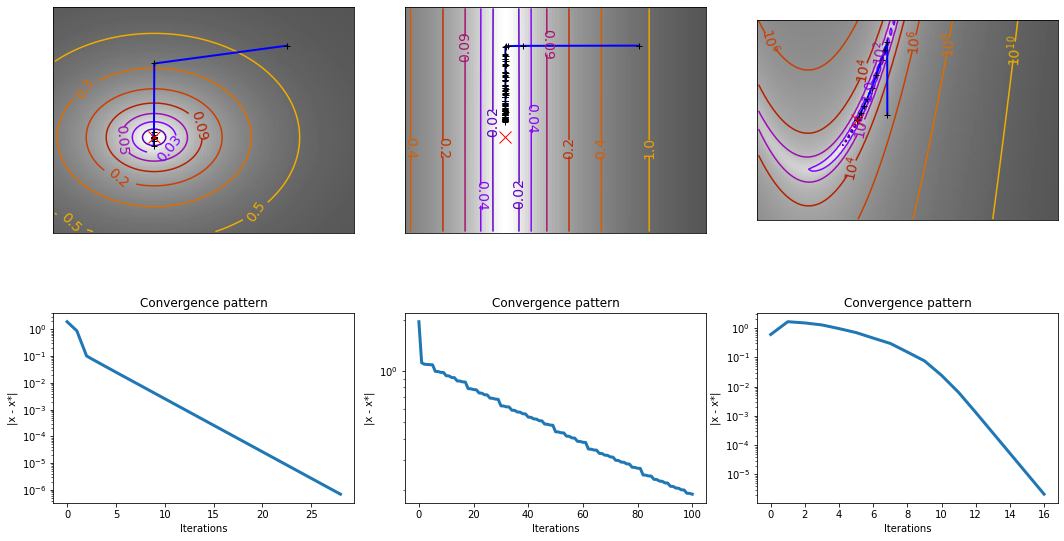

In [82]:
test_solver(newton)

**COMMENTS HERE**
* Effect of **lambda_threshold**: We have
$$d_k = - (H_k + \lambda I_n)^{-1}\nabla f(x_k)$$
Therefore, for $\lambda$ Large ($\geq 0.1$), this method is equivalent to a Gradient Descent method. Hence, it has a quick convergence for steep fields, and slow convergence for flat fields (linear convergence). For example, works badly for the ill-conditionned quadratic function after immediately reaching the valley, or rapidly converges to the center of the Gaussian kernel, but then gradually converge to minimum. <br/>
On the other hand, for a small $\lambda$, this behaves like a pure Newton's method. Thus, it converges rapidly for a quadratic function. For the Gaussian kernel, as the gradient tends to zero for large values of $x$ and as the initial point is quite far from the minimum, the line search fails to converge at the first iterations, and for very small values of $\lambda$ $(\leq 10^{-6})$ the method diverges. 

* For the **Rosenbrock function**, we observe the expected behavior for Newton's method, slow convergence at first, then start to shrink quadratically in a neighborhood of the minimum.

# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [0]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.4
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None or new_grad is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step
            new_grad = grad_x

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO
        term_1 = np.outer(s, s.T) / (s.T @ y)
        term_2 = B @ np.outer(y, y.T) @ B / (y.T @ B @ y)
        B += (term_1 - term_2)
        
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


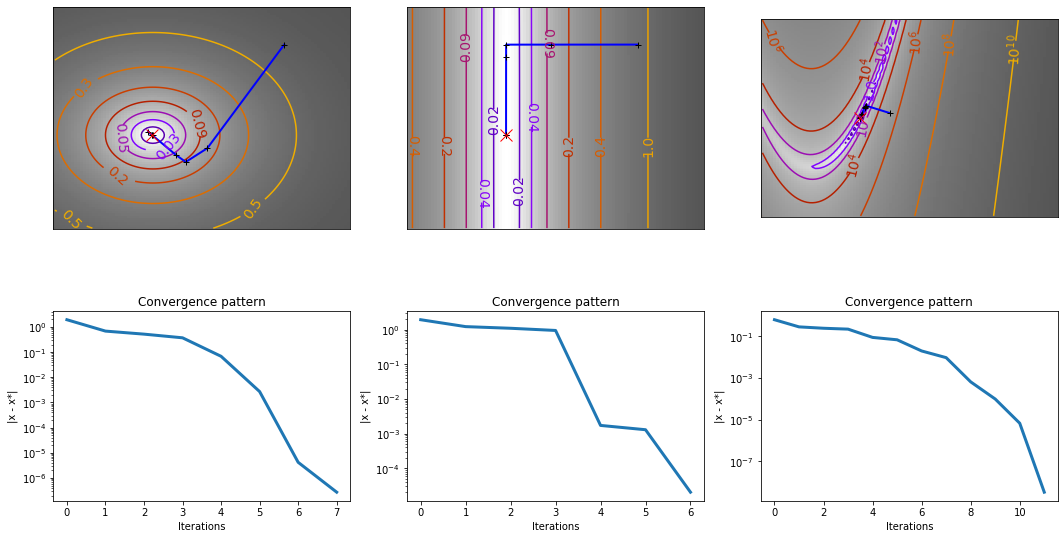

In [90]:
test_solver(dfp)

#### Your comments here
* This algorithm combines the advantages of the gradient descent and Newton's methods. At the first iteration, $B_0=I_n$ hence it's equivalent to Gradient Descent. This helps the point to jump quickly into a neighborhood of the minimum. Then $B_k$ starts to converge to the inverse Hessian, which turns it into a nearly Newton method and by consequence converge in a very small number of iterations (with appropriate line search parameters, of course).
* Sensitive to line search parameters:
    * If $c_1$ is too small, the security interval can be larger and therefore the step size may be too big. For example when setting $c_1 = 0.0001$, for the Rosenbrock function the first iteration goes too far and therefore it takes a long time to converge. If $c_1$ is too big (>0.5), then the view for line search is too narrow. Thus, the step sizes are rejected. Sometimes this results in the line search not finding any optimal step size. The optimization could diverge if the default step size is big.
    * If $c_2$ is not big enough $(\approx 0.9)$, then like for big $c_1$, the view for line search could be too narrow, hence line search cannot be performed properly and the step sizes are rejected. As the gradients are constrained to be small, the optimization of the ill-conditioned quadratic function could be trapped when reaching the valley . It therefore never reaches the optimum point.

# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [0]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.4
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    H = np.eye(len(x))  # Hessian approximation
    B = np.eye(len(x))
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None or new_grad is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step
            new_grad = grad_x
        
        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO
        term_1 = np.outer(y, y.T) / (y.T @ s)
        term_2 = H @ np.outer(s, s.T) @ H / (s.T @ H @ s)
        H += (term_1 - term_2)
        
        B = np.linalg.inv(H)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


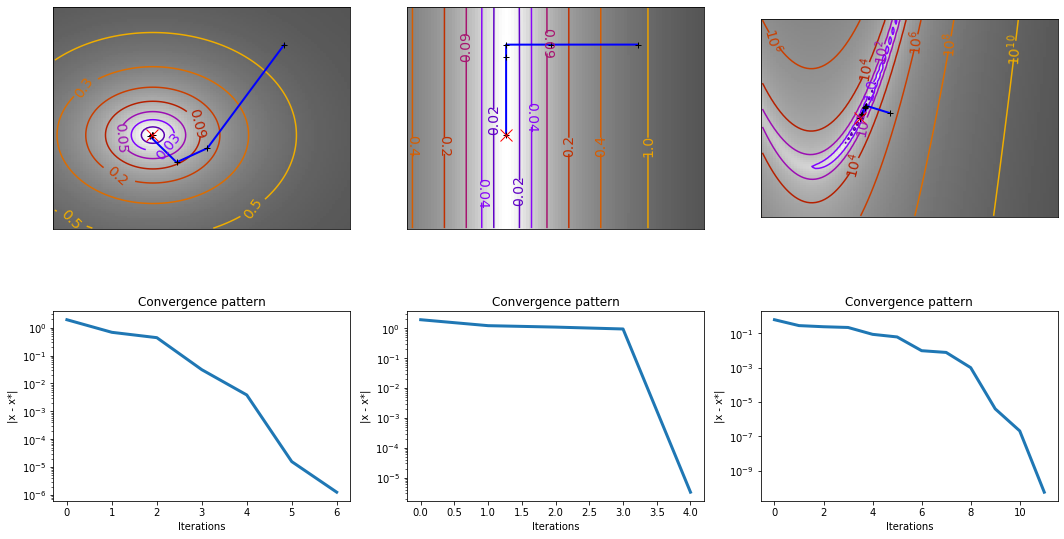

In [102]:
test_solver(bfgs)

#### Your comments here
- This method is a rank 2 correction as DFP, so it presents almost the same advantages, say the equilibrium between gradient descent and Newton's method. For the ill conditioned quadratic function, it behaves as a conjugate gradient method and converges quickly when it is in the neighborhood of the minimizer.

- This method is more robust to the use of a less precise step size, but it still is sensible to the parameters of line search.
    - For big values of $c1$, the stepsize is constrained to be big. This could lead to not being able to compute the optimal stepsize for the Roosenbrock function. In this case, it diverges if the default step size is big.
    -  The smaller the value of $c2$, the smaller the value of the gradient. If $c2 \lt 0.86$, it is so small that the line search procedure fails in the second case. Then, the ill conditioned quadratic function could be trapped and never reach the minimum if the default step size is too small. For values of $c2$ near 1, the step size is slightly bigger and bigger, but it still converges in all cases.


# Part 4: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [0]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    if len(rho_list) < m:
        m = len(rho_list)
    # TODO : first loop
    for i in reversed(range(m)):
        alpha = rho_list[i] *(s_list[i].T @ q)
        q -= alpha * y_list[i]
        alpha_list.append(alpha)
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(m):
        beta = rho_list[i] *(y_list[i].T @ r)
        r += s_list[i]*(alpha_list[m-1-i] - beta)
    return -r

In [0]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.4
    c2 = 0.9
    max_iter = 100
    m = 5
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None or new_grad is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step
            new_grad = grad_x
        
        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


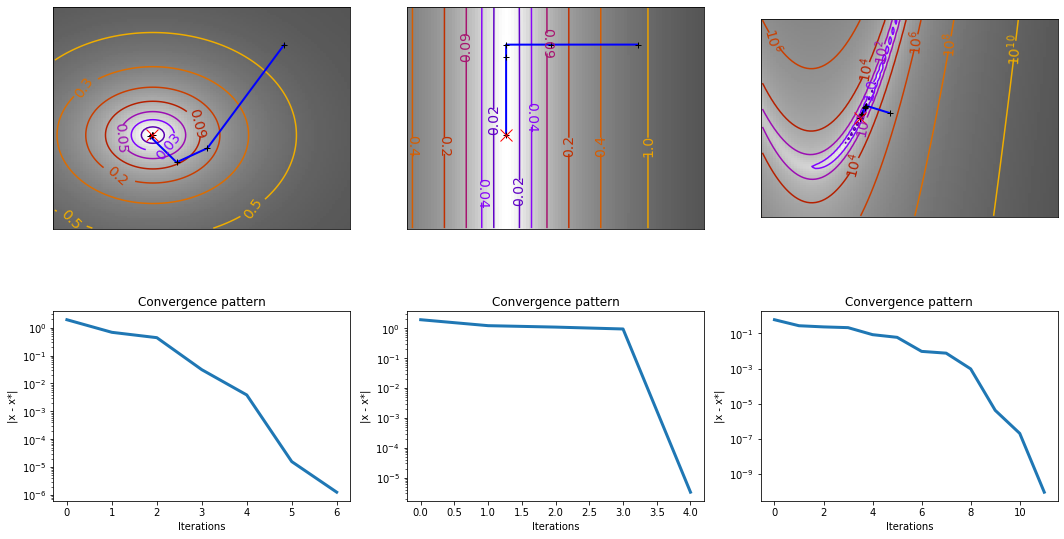

In [74]:
test_solver(lbfgs)

**Comment on what you observe**
- This method presents the same behavior as the BGFS with respect to the parameters of c1 and c2. 
- When varying m
    - If $m=0$, L-BGFS behaves as a gradient descent and presents the same problems for the ill conditioned quadratic or the Rosenbrock functions. It get stuck in the point of a tiny gradient.
    - If $m=1$, it starts to work as BGFS. However, it is a little inestable for the quadratic function and it takes longer to reach the minimum. For bigger values, it is like BGFS.